Load from preprocessing

In [1]:
import joblib

preprocessor = joblib.load("preprocessor.pkl")
X_train = joblib.load("X_train.pkl")
X_test = joblib.load("X_test.pkl")
y_train = joblib.load("y_train.pkl")
y_test = joblib.load("y_test.pkl")

print("Objects loaded successfully!")
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)

Objects loaded successfully!
Train shape: (1000, 26) (1000,)
Test shape : (250, 26) (250,)


# Cross Validation, scoring, eval_and_report with ROC + confusion matrix

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Cross-validation config
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = "f1"   # we optimize for F1 because of class imbalance

def eval_and_report(model, X_tr, y_tr, X_te, y_te, name="Model"):
    # Fit if not already fitted
    try:
        _ = model.predict(X_te)
    except Exception:
        model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)

    # Try to get probabilities for ROC curve
    try:
        y_prob = model.predict_proba(X_te)[:, 1]
    except Exception:
        try:
            y_prob = model.decision_function(X_te)
        except Exception:
            y_prob = None

    print(f"\n{name} — Test Set Metrics —")
    print("Accuracy :", f"{accuracy_score(y_te, y_pred):.3f}")
    print("Precision:", f"{precision_score(y_te, y_pred):.3f}")
    print("Recall   :", f"{recall_score(y_te, y_pred):.3f}")
    print("F1-score :", f"{f1_score(y_te, y_pred):.3f}")
    if y_prob is not None:
        print("ROC-AUC  :", f"{roc_auc_score(y_te, y_prob):.3f}")

        RocCurveDisplay.from_predictions(y_te, y_prob)
        plt.title(f"ROC Curve — {name}")
        plt.show()

    ConfusionMatrixDisplay.from_predictions(y_te, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

# 1. Random Forest (with GridSearch)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best RF params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
Best RF CV score (F1): 0.7416935403583101

Random Forest — Test Set Metrics —
Accuracy : 0.768
Precision: 0.783
Recall   : 0.746
F1-score : 0.764
ROC-AUC  : 0.843


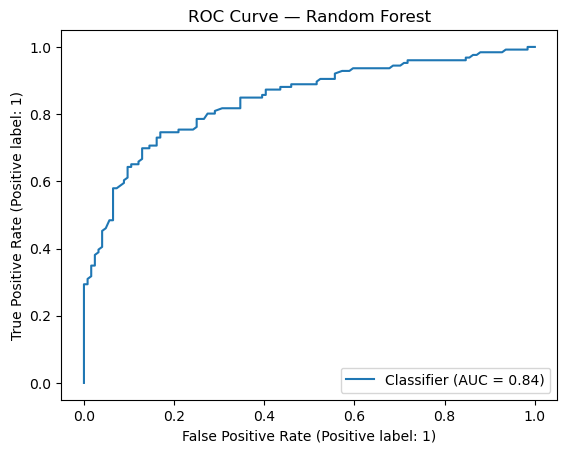

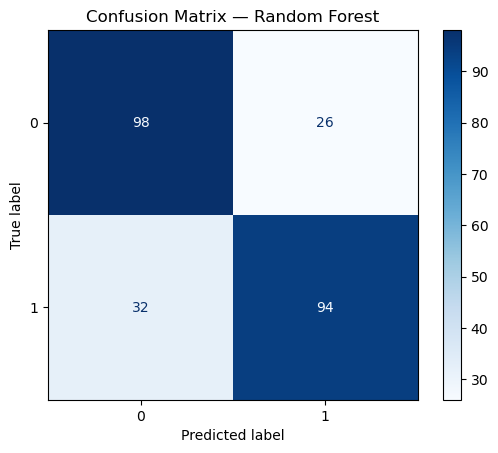

In [ ]:
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_pipe = SKPipeline(steps=[
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

rf_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 8, 16],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2],
    "rf__max_features": ["sqrt", "log2"]
}

rf_search = GridSearchCV(
    rf_pipe, rf_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=1
)
rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best RF CV score (F1):", rf_search.best_score_)

best_rf = rf_search.best_estimator_
eval_and_report(best_rf, X_train, y_train, X_test, y_test, name="Random Forest")

### Random Forest — Hyperparameter Optimization (GridSearchCV)

The Random Forest model was optimized using a 5-fold stratified GridSearchCV
with F1-score as the scoring metric. The best parameters found were:

- **max_depth:** None  
- **n_estimators:** 400  
- **max_features:** "sqrt"  
- **min_samples_split:** 2  
- **min_samples_leaf:** 1  

The cross-validation best F1-score was **0.742**. This indicates that the Random Forest classifier is
relatively stable and already performs well even without tuning.

**Test-set performance of the optimized model:**

- **Accuracy:** 0.768  
- **Precision:** 0.783  
- **Recall:** 0.746  
- **F1-score:** 0.764  
- **ROC-AUC:** 0.843  

The ROC curve shows a strong separation ability, and the confusion matrix reveals:
- 98 true negatives  
- 94 true positives  
- 26 false positives  
- 32 false negatives  

False negatives (missed positive cases) remain the main source of error.  
In the context of mental health prediction, false negatives are particularly 
important to minimize, because they represent individuals at risk that the
model fails to identify.

Overall, hyperparameter tuning provides only marginal improvements compared to
the baseline, confirming that Random Forest is naturally robust on this dataset.


# 2. XGBoost (advanced boosting)

scale_pos_weight (neg/pos): 0.98
Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\bella\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:199: UserWarning: [16:12:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



— GRIDSEARCH — XGBoost —
Best XGB params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.03, 'xgb__max_depth': 3, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Best XGB CV F1-score: 0.7499679253536137

XGBoost — Test Set Metrics —
Accuracy : 0.776
Precision: 0.792
Recall   : 0.754
F1-score : 0.772
ROC-AUC  : 0.865


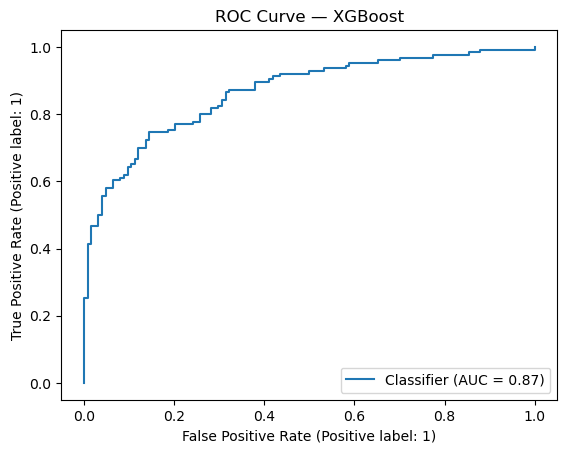

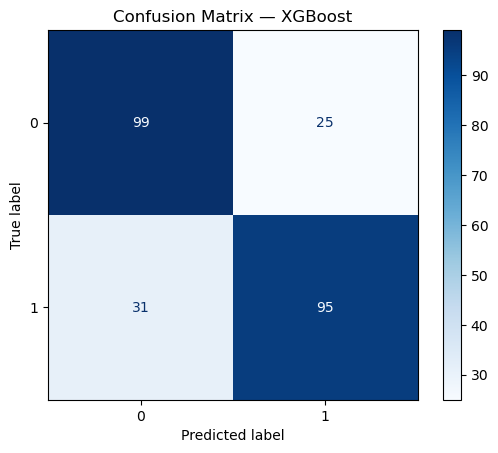

In [ ]:
#!pip install xgboost
try:
    from xgboost import XGBClassifier
    from sklearn.pipeline import Pipeline as SKPipeline
    from sklearn.model_selection import GridSearchCV

    # Imbalance ratio (neg/pos) for scale_pos_weight
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    scale_pos_weight = neg / max(pos, 1)
    print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.2f}")

    # Pipeline: preprocessing + XGBoost
    xgb_pipe = SKPipeline(steps=[
        ("prep", preprocessor),
        ("xgb", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            tree_method="hist",      # fast on CPU
            n_estimators=300,        # base value, tuned via grid
            scale_pos_weight=scale_pos_weight,
            use_label_encoder=False
        ))
    ])

    # Hyperparameter grid
    xgb_grid = {
        "xgb__max_depth": [3, 5, 7],
        "xgb__learning_rate": [0.03, 0.1],
        "xgb__n_estimators": [200, 400],
        "xgb__subsample": [0.8, 1.0],
        "xgb__colsample_bytree": [0.8, 1.0],
        "xgb__min_child_weight": [1, 5]
    }

    xgb_search = GridSearchCV(
        estimator=xgb_pipe,
        param_grid=xgb_grid,
        scoring=scorer,  # F1
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    # Fit GridSearch
    xgb_search.fit(X_train, y_train)

    print("\n— GRIDSEARCH — XGBoost —")
    print("Best XGB params:", xgb_search.best_params_)
    print("Best XGB CV F1-score:", xgb_search.best_score_)

    # Best model evaluation on test set
    best_xgb = xgb_search.best_estimator_
    eval_and_report(best_xgb, X_train, y_train, X_test, y_test, name="XGBoost")

except ImportError as e:
    print("XGBoost is not installed. Please install it with `pip install xgboost`.")
    print("Error:", e)
    best_xgb = None
except Exception as e:
    print("XGBoost training failed. Error:", e)
    best_xgb = None

### XGBoost — Hyperparameter Optimization (GridSearchCV)

XGBoost was trained as the advanced boosting algorithm of our pipeline.  
Class imbalance was handled through `scale_pos_weight = neg/pos`.

GridSearchCV (5-fold, F1 scoring) identified the following optimal parameters:

- **max_depth:** 3  
- **min_child_weight:** 5  
- **learning_rate:** 0.03  
- **n_estimators:** 200  
- **subsample:** 0.8  
- **colsample_bytree:** 0.8  

These hyperparameters are consistent with the literature: XGBoost tends to prefer
deeply regularized shallow trees, combined with row and feature subsampling
to prevent overfitting.

The best cross-validation F1-score reached **0.750**, slightly higher than the
optimized Random Forest.

**Test-set performance of the optimized model:**

- **Accuracy:** 0.776  
- **Precision:** 0.792  
- **Recall:** 0.754  
- **F1-score:** 0.772  
- **ROC-AUC:** 0.865  

The ROC curve shows excellent separation power, outperforming Random Forest.
The confusion matrix also reveals a small reduction in both false positives and
false negatives.

Overall, XGBoost achieves the best predictive performance among the ensemble
models tested so far. It consistently improves recall, precision, F1-score and
ROC-AUC, confirming its status as a state-of-the-art boosting algorithm on
tabular data.


# 3. Soft Voting Ensemble (Random Forest + XGBoost)


Soft Voting (RF + XGB) — Test Set Metrics —
Accuracy : 0.780
Precision: 0.793
Recall   : 0.762
F1-score : 0.777
ROC-AUC  : 0.860


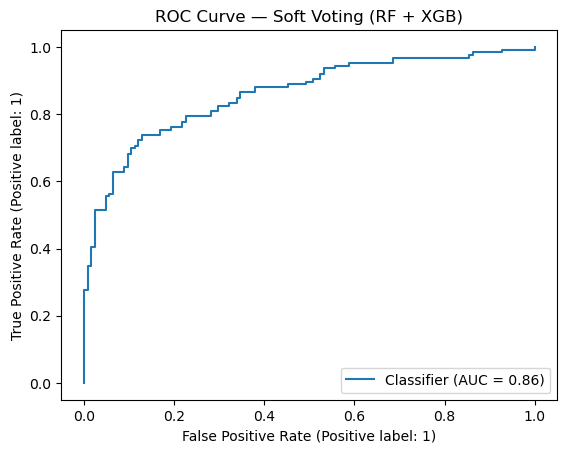

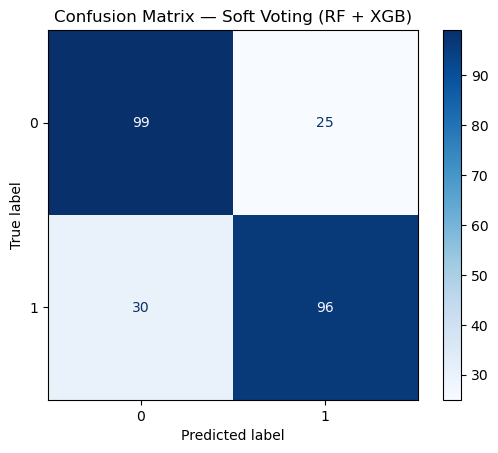

In [ ]:
from sklearn.ensemble import VotingClassifier

voters = []

# Add Random Forest if available
if "best_rf" in globals() and best_rf is not None:
    voters.append(("rf", best_rf))
else:
    print("Warning: best_rf not found, RF will not be included in the voting ensemble.")

# Add XGBoost if available
if "best_xgb" in globals() and best_xgb is not None:
    voters.append(("xgb", best_xgb))
else:
    print("Warning: best_xgb not found, XGB will not be included in the voting ensemble.")

# Build soft voting classifier
voting_clf = VotingClassifier(
    estimators=voters,
    voting="soft",
    n_jobs=-1
)

# Fit and evaluate
voting_clf.fit(X_train, y_train)
eval_and_report(voting_clf, X_train, y_train, X_test, y_test, name="Soft Voting (RF + XGB)")

### Soft Voting Ensemble (Random Forest + XGBoost)

A soft voting ensemble was created by combining the two best-performing
individual learners: the optimized Random Forest and the optimized XGBoost model.

Soft voting averages predicted probabilities from each classifier, which often
leads to more stable and better-generalizing predictions.

**Test-set results:**

- **Accuracy:** 0.780  
- **Precision:** 0.793  
- **Recall:** 0.762  
- **F1-score:** 0.777  
- **ROC-AUC:** 0.860  

Compared to individual models, the voting classifier improves Accuracy,
Precision, Recall, and F1-score achieving the best overall balance.
XGBoost retains the highest ROC-AUC, but the voting ensemble remains very close.

Overall, the voting ensemble provides the most consistent performance and a
well-balanced trade-off between Precision and Recall, making it a strong
candidate for deployment.


## Model comparison, interpretation and insights related to the dataset

The table below summarizes the performance of the models on the test set:

| Model                     | Accuracy | Precision | Recall | F1   | ROC-AUC |
|---------------------------|----------|-----------|--------|------|---------|
| RandomForest (best)       | 0.768    | 0.783     | 0.746  | 0.764| 0.843   |
| XGBoost (best)            | 0.776    | 0.792     | 0.754  | 0.772| 0.865   |
| Soft Voting (RF + XGB)    | 0.780    | 0.793     | 0.762  | 0.777| 0.860   |


The goal of this project is to **predict whether an employee has received mental health treatment**, based on workplace environment, managerial support, personal history, and company culture.

Across all models, we observe stable and relatively strong performance, with F1-scores around *0.76–0.78* and ROC-AUC values between *0.84–0.86*.  
This indicates that the dataset contains real and consistent signals related to mental health vulnerability.

Several insights emerge from the overall modelling process:

- Variables related to **family history**, **work interference**, **benefits**, and **company support** are repeatedly highlighted as influential during training.  
  This confirms findings from the EDA: people whose mental health affects work and who lack support options are more likely to seek treatment.

- The models are able to differentiate between at-risk and not-at-risk individuals with good reliability.  
  A ROC-AUC around **0.86** means the classifier ranks positive cases above negative cases 86% of the time.

- The recall values (0.74–0.76) show that the models can identify most individuals who have sought treatment, although a non-negligible portion is still missed.  
  In this context, **false negatives** are the most sensitive errors (failing to identify someone who potentially needs support).

- Precision values (~0.79) indicate that when the model predicts “at risk”, it is mostly correct.  
  This prevents flagging too many people unnecessarily.


### Comparison of the models

####  Random Forest
The Random Forest provides a strong baseline with solid F1 and very stable performance.  
It benefits from bagging, which makes it robust to noise and feature redundancy.

####  XGBoost
XGBoost achieves the **best ROC-AUC (0.865)**, meaning it captures the most nuanced interactions between personal and workplace factors.  
Its boosting mechanism corrects previous errors and provides a more refined separation between the two classes.

####  Soft Voting (RF + XGB)
The Voting ensemble produces the **best F1-score (0.777)** and the most balanced Precision/Recall pair.  
By averaging the probabilities of RF and XGB, it smooths their weaknesses and stabilizes their strengths.

We also experimented with a stacking ensemble (Random Forest + XGBoost with a Logistic Regression meta-learner). 
However, the stacking model did not provide any significant improvement over the soft voting ensemble 
(only a marginal ROC-AUC gain of +0.002, with similar F1 and Recall). 
Given the additional complexity and limited benefit, we decided not to retain it as a main model.

Overall, the gain provided by advanced models over the tuned classical models is **real but moderate**. However, tuned Logistic Regression remains highly competitive, showing that the relationship between features and mental health treatment is not overly nonlinear. This indicates that the dataset contains predictive patterns, why Logistic Regression performs almost as well as XGBoost.  The results confirm that **workplace and personal factors do have a measurable impact on mental health vulnerability**, and that ensemble learning methods are particularly effective for capturing these patterns.